# Spam Classification with TensorFlow

---

## 1. Import TensorFlow and Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2022-05-30 19:41:07.502509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 19:41:07.502623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dataset = pd.read_csv('./data/spam.csv')
dataset

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [3]:
# ham = 0, spam = 1

sentences = dataset['Message'].tolist()
labels = dataset['Category'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## 2. Tokenize the dataset

Tokenize the dataset, including padding and OOV

In [4]:
vocab_size = 600
embedding_dim = 16
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

## 3. Review a Sequence

Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

ok lar <OOV> wif u <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Ok lar... Joking wif u oni...


## 4. Train a Text Classification Model with Embeddings

In [6]:
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 16)            9600      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 9,709
Trainable params: 9,709
Non-trainable params: 0
_________________________________________________________________


2022-05-30 19:41:27.124049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 19:41:27.124151: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 19:41:27.124259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udit-HP-245-G6-Notebook-PC): /proc/driver/nvidia/version does not exist
2022-05-30 19:41:27.125097: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
num_epochs = 30
history=model.fit(
    padded, 
    training_labels_final, 
    epochs=num_epochs, 
    validation_data=(testing_padded, testing_labels_final)
)

Epoch 1/30
140/140 [==============================] - 5s 18ms/step - loss: 0.5350 - accuracy: 0.8582 - val_loss: 0.3838 - val_accuracy: 0.8700
Epoch 2/30
140/140 [==============================] - 2s 12ms/step - loss: 0.3419 - accuracy: 0.8649 - val_loss: 0.3005 - val_accuracy: 0.8700
Epoch 3/30
140/140 [==============================] - 1s 10ms/step - loss: 0.2772 - accuracy: 0.8658 - val_loss: 0.2266 - val_accuracy: 0.8771
Epoch 4/30
140/140 [==============================] - 2s 12ms/step - loss: 0.1958 - accuracy: 0.9181 - val_loss: 0.1511 - val_accuracy: 0.9623
Epoch 5/30
140/140 [==============================] - 1s 10ms/step - loss: 0.1383 - accuracy: 0.9574 - val_loss: 0.1106 - val_accuracy: 0.9695
Epoch 6/30
140/140 [==============================] - 2s 11ms/step - loss: 0.1057 - accuracy: 0.9681 - val_loss: 0.0876 - val_accuracy: 0.9722
Epoch 7/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0861 - accuracy: 0.9742 - val_loss: 0.0739 - val_accuracy: 0.9767

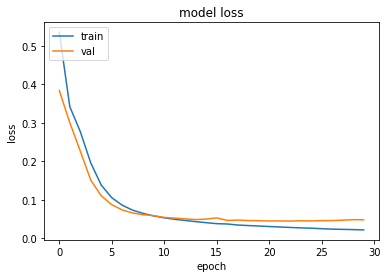

In [8]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 5. Detecting Spam Across New Messages

In [9]:
# Use the model to predict whether a message is spam
text_messages = ['Greg, can you call me back once you get this?',
                'Congrats on your new iPhone! Click here to claim your prize...', 
                'Really like that new photo of you',
                'Did you hear the news today? Terrible what has happened...',
                'Attend this free COVID webinar today: Book your session now...',
                'Are you coming to the party tonight?',
                'Your parcel has gone missing',
                'Do not forget to bring friends!',
                'You have won a million dollars! Fill out your bank details here...',
                'Looking forward to seeing you again']

print(text_messages) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(text_messages)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(text_messages)):
    print(text_messages[x])
    print(classes[x])
    print('\n')

['Greg, can you call me back once you get this?', 'Congrats on your new iPhone! Click here to claim your prize...', 'Really like that new photo of you', 'Did you hear the news today? Terrible what has happened...', 'Attend this free COVID webinar today: Book your session now...', 'Are you coming to the party tonight?', 'Your parcel has gone missing', 'Do not forget to bring friends!', 'You have won a million dollars! Fill out your bank details here...', 'Looking forward to seeing you again']
Greg, can you call me back once you get this?
[0.0242843]


Congrats on your new iPhone! Click here to claim your prize...
[0.9595318]


Really like that new photo of you
[0.00937355]


Did you hear the news today? Terrible what has happened...
[0.01608324]


Attend this free COVID webinar today: Book your session now...
[0.40513515]


Are you coming to the party tonight?
[0.00283235]


Your parcel has gone missing
[0.01094836]


Do not forget to bring friends!
[0.00035253]


You have won a million